In [38]:
import os
os.chdir('/content/drive/MyDrive/9조 프로젝트/Data/Dataset')

In [3]:
pip install datasets

In [4]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "google/vit-base-patch16-224-in21k"  # embedding matrix  N X 768
#model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size # 768

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
from datasets import load_from_disk

dataset_dict = load_from_disk("arrow_dataset_dict")

In [28]:
labels = dataset_dict["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [6]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize((224, 224)),
        #T.Resize(int((256 / 224) * extractor.size["height"])),
        #T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [7]:
import torch

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()  # 임베딩 계산
        return {"embeddings": embeddings}

    return pp

In [25]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

In [8]:
import numpy as np

hash_size = 8

# Define random vectors to project with.
random_vectors = np.random.randn(hash_size, hidden_dim).T  # (768, 8)


def hash_func(embedding, random_vectors=random_vectors):
    """Randomly projects the embeddings and then computes bit-wise hashes."""
    if not isinstance(embedding, np.ndarray):
        embedding = np.array(embedding)
    if len(embedding.shape) < 2:
        embedding = np.expand_dims(embedding, 0)

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y

In [9]:
from typing import Union
import torch

def compute_hash(model: Union[torch.nn.Module, str]):
    """Computes hash on a given dataset."""
    device = model.device

    def pp(example_batch):
        # Prepare the input images for the model.
        image_batch = example_batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in image_batch]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}

        # Compute embeddings and pool them i.e., take the representations from the [CLS]
        # token.
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu().numpy()

        # Compute hashes for the batch of images.
        hashes = [hash_func(embeddings[i]) for i in range(len(embeddings))]
        example_batch["hashes"] = hashes
        return example_batch

    return pp

해시 테이블 구축하는 세 가지 유틸리티

In [10]:
# Table
from typing import List

class Table :
    def __init__(self, hash_size: int) :
        self.table = {}
        self.hash_size = hash_size

    def add(self, id: int, hashes: List[int], label: int) :  # 후보 이미지의 해시를 식별자에 매핑하는 사전을 구축
        # Create a unique indentifier.
        entry = {"id_label": str(id) + "_" + str(label)}

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, hashes: List[int]) :  # 쿼리 해시를 입력으로 사용하여 테이블에 있는지 확인
        results = []

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results

In [11]:
# LSH : 차원 축소에 무작위성 포함 ; 비슷한 이미지가 같은 해시 버킷에 매핑되지 않는 상황을 초래 -> 여러가지 해시테이블 유지
class LSH:
    def __init__(self, hash_size, num_tables):
        self.num_tables = num_tables
        self.tables = []
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size))

    def add(self, id: int, hash: List[int], label: int):
        for table in self.tables:
            table.add(id, hash, label)

    def query(self, hashes: List[int]):
        results = []
        for table in self.tables:
            results.extend(table.query(hashes))
        return results

In [16]:
# BuildLSHTable
device = "cuda" if torch.cuda.is_available() else "cpu"

from PIL import Image
import datasets
import tqdm
from tqdm.auto import tqdm


class BuildLSHTable :
    def __init__(
        self,
        model: Union[torch.nn.Module, None],
        batch_size: int = 48,
        hash_size: int = hash_size,
        dim: int = hidden_dim,
        num_tables: int = 10,
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.num_tables)

        self.batch_size = batch_size
        self.hash_fn = compute_hash(model.to(device))

    def build(self, ds: datasets.DatasetDict) :  # 해시 테이블 만듦 : 해시 계산하고 LSH Table에 추가
        dataset_hashed = ds.map(self.hash_fn, batched=True, batch_size=self.batch_size)

        for id in tqdm(range(len(dataset_hashed))):
            hash, label = dataset_hashed[id]["hashes"], dataset_hashed[id]["label"]
            self.lsh.add(id, hash, label)

    def query(self, image, verbose=True) : # 입력 이미지 (쿼리 이미지) 해시 계산하고 LSH 사용하여 근접 이웃 찾음
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        # Compute the hashes of the query image and fetch the results.
        example_batch = dict(image=[image])
        hashes = self.hash_fn(example_batch)["hashes"][0]

        results = self.lsh.query(hashes)
        if verbose:
            print("Matches:", len(results))

        # Jaccard index를 계산하여 유사성을 측정
        counts = {}
        for r in results :
            if r["id_label"] in counts :
                counts[r["id_label"]] += 1
            else:
                counts[r["id_label"]] = 1
        for k in counts:
            counts[k] = float(counts[k]) / self.dim
        return counts

Jaccard 인덱스를 사용하여 쿼리 이미지와 후보 이미지 간의 유사성을 정량화함  
교차점의 크기를 두 레이블 집합의 결합 크기로 나눈 값으로 정의  
LSH를 사용하여 유사성 시스템을 구축하고 해시가 효과적으로 설정되기 때문에 Jaccard 인덱스를 사용하는 것이 좋다.



In [17]:
lsh_builder = BuildLSHTable(model)
lsh_builder.build(dataset_dict["train"].shuffle(seed=42))

  0%|          | 0/17459 [00:00<?, ?it/s]

In [85]:
idx = 0
for hash, entry in lsh_builder.lsh.tables[0].table.items(): # 왜 0 인덱스를 가져오는지 모르겠음
    if idx == 5:
        break
    if len(entry) < 5:
        print(f"Hash: {hash}, entries: {entry}")
        idx += 1

Hash: 40, entries: [{'id_label': '961_0'}, {'id_label': '6148_2'}, {'id_label': '13990_7'}, {'id_label': '15575_2'}]


In [77]:
len(lsh_builder.lsh.tables)

10

In [51]:
len(lsh_builder.lsh.tables[0].table)

256

In [63]:
lst=[]
for i in range(256) :
  lst.append(len(lsh_builder.lsh.tables[0].table[i]))

In [64]:
sum(lst)

17459

In [73]:
candidate_dataset = dataset_dict["train"].shuffle(seed=42)


def visualize_lsh(lsh_class: BuildLSHTable, top_k: int = 5):
    idx = np.random.choice(len(dataset_dict["test"]))


    image = dataset_dict["test"][idx]["image"]
    label = dataset_dict["test"][idx]["label"]
    results = lsh_class.query(image)

    candidates = []
    labels = []
    overlaps = []

    for idx, r in enumerate(sorted(results, key=results.get, reverse=True)):
        if idx == top_k:
            break
        image_id, label = r.split("_")[0], r.split("_")[1]
        candidates.append(candidate_dataset[int(image_id)]["image"])
        labels.append(label)
        overlaps.append(results[r])

    candidates.insert(0, image)
    labels.insert(0, label)

    plot_images(candidates, labels)

In [72]:
idx = np.random.choice(len(dataset_dict["test"]))
idx

56

Matches: 3570


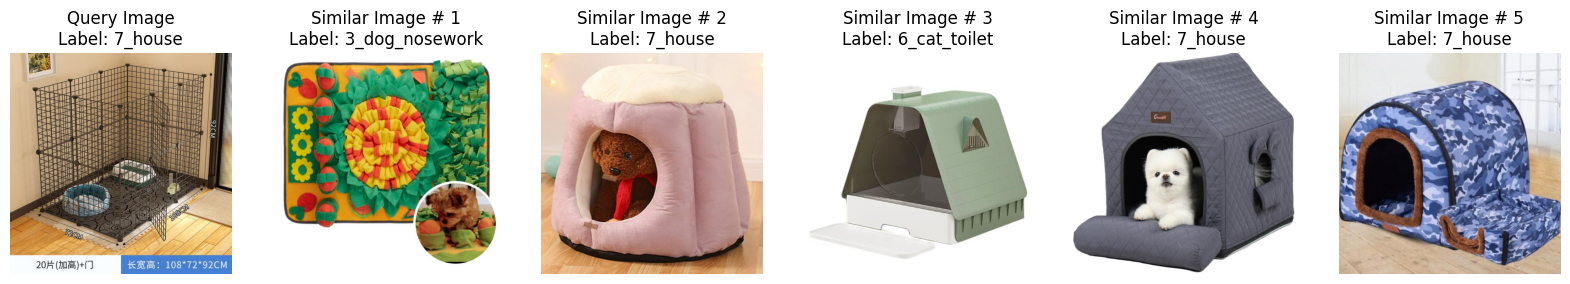

In [74]:
visualize_lsh(lsh_builder)

In [29]:
for _ in range(5):
    visualize_lsh(lsh_builder)

Output hidden; open in https://colab.research.google.com to view.

In [40]:
import pickle

with open("lsh_builder.pickle", "wb") as handle:
    pickle.dump(lsh_builder.lsh, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
with open("lsh.pickle", "rb") as handle:
    lsh_cls = pickle.load(handle)

lsh_builder = BuildLSHTable(model)
lsh_builder.lsh = lsh_cls